In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

from lib_classifNN import *
from lib_visu_classif import *

from tqdm import tqdm
"""In this file, we create a neural network with one hidden layer and apply it to the not_mnist dataset in order to address the classification problem and computing uncertainty as developped in  Y. Gal and Z. Ghahramani, “Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning,” Apr. 2016.
"""

path = 'data/notmnist_train.npy'

Using TensorFlow backend.


In [3]:
#loading data
data = np.load(path)
#dictionnary to swap between numerical label and letter
letter2label = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], np.arange(10)))
label2letter = dict(zip(np.arange(10), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']))

In [4]:
# separing to test and train datasets
sep = 80000
x_train = data.tolist()["x_train"][:sep]
x_test = data.tolist()["x_train"][sep:]

y_train = data.tolist()["y_train"][:sep]
y_test = data.tolist()["y_train"][sep:]


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# network parameters
batch_size = 128
num_classes = 10
epochs = 20

# dimensions for the NN:
# input dimension
Q = x_train.shape[1]
# hidden layer dimension
K = 100
# output dimension : classification
D = num_classes

# dropout rate
DROP_OUT = 0.5
N = x_train.shape[0]
# l2 regularization
#prior length scale
l = 1e-2
# precision parameter
tau = 1e-1

lambd = DROP_OUT*l**2/(2*N)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("----------Data loaded and preprocessed----------")

80000 train samples
20000 test samples
----------Data loaded and preprocessed----------


In [6]:
# Create the neural network model and train it
model = Sequential()
model.add(Dense(K, input_shape = (Q, ), activation = 'relu', use_bias= True, kernel_regularizer = regularizers.l2(lambd), bias_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
# softmax layer
model.add(Dense(num_classes, use_bias = False, activation = None, kernel_regularizer = regularizers.l2(lambd)))
model.add(Dropout(DROP_OUT))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

print("----------Model built---------")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 79,500
Trainable params: 79,500
Non-trainable params: 0
_________________________________________________________________
----------Model built---------


In [7]:
print("----------Training the model...---------")
# Training the network
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

# Evaluation of the network
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

----------Training the model...---------
Test loss: 0.553527466166
Test accuracy: 0.85085


## Plot the confidence distribution for one rotated image

----------Assessing uncertainty for rotated example of a data point---------


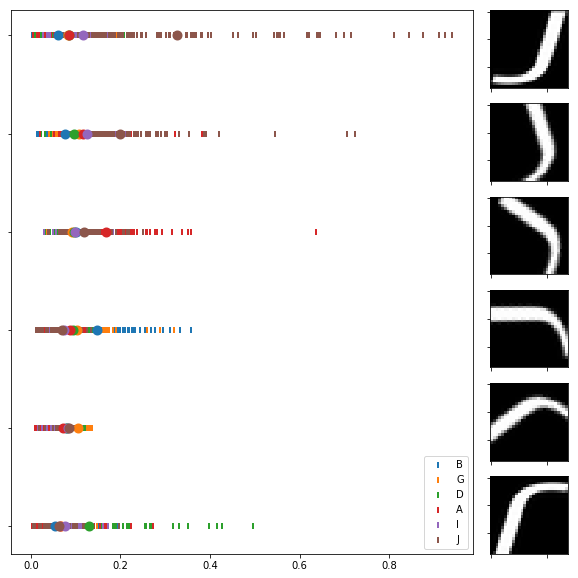

In [8]:
print("----------Assessing uncertainty for rotated example of a data point---------")
#DROP_OUT = 0.5
# change this to see more or less classes
NB_SHOW = 6
# select the index for the image sample
ix = 15541
x_ex = x_test[ix]
plot_rotated(x_ex, model , nb_class=10, label2name= label2letter, nb_show = NB_SHOW, drop_out = DROP_OUT)
plt.show()

## Visualize one image and its confidence prediction 

Network prediction: [[  9.30411652e-15   1.95666576e-14   9.99999642e-01   6.25899004e-14
    8.63907204e-08   1.92905525e-10   2.97723403e-07   3.34041906e-15
    2.00815101e-10   3.36727196e-12]]
Networ label: 2
dropout prediction: [ 0.00883723  0.01080263  0.74907991  0.01285011  0.05218973  0.02219186
  0.06797385  0.00926891  0.0407686   0.02603716]
dropout label: 2
real label: 2


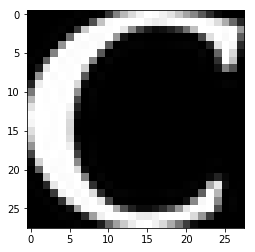

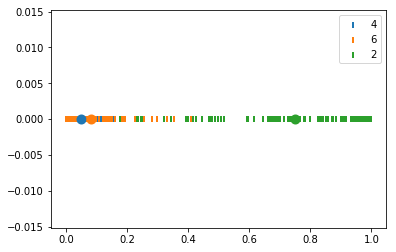

In [9]:
# Rough comparison between the classic neural network and the bayesian estimation
# change the drop_out rate (by default to 0.5)
DROP_OUT = 0.5
ix = 8
x_ex = x_test[ix]
print("Network prediction: " + str(model.predict(x_ex.reshape((1, -1)))))
print("Networ label: "+ str(np.argmax(model.predict(x_ex.reshape((1, -1))))))

print("dropout prediction: "+ str(dropout_pred(x_ex, model, nb_cl=10, drop_out = DROP_OUT)))
print("dropout label: "+ str(dropout_pred(x_ex, model, nb_cl=10, label=True, drop_out = DROP_OUT)))

print("real label: " + str(np.argmax(y_test[ix])))

x_pl = x_ex.reshape((28,28))
plt.imshow(x_pl, cmap = "gray")
plt.show()

classes = np.argsort(model.predict(x_ex.reshape(1,-1))[0])[-3:]
S_in, S_out = softmax_in_out(x_ex, model, nb_cl=10, drop_out=DROP_OUT)
plot_pred(S_out, classes, legend=True)
plt.show()